<a href="https://colab.research.google.com/github/pranavsinghal30/DSR_LAB/blob/master/Batch_Processing_field_water_body_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mounting Google Drive**

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Installing dependencies**

---



In [2]:
!pip install "rtree>=0.8,<0.9"
!pip install geopandas
!sudo apt install python3-rtree
!sudo apt-get update
!sudo apt-get install libspatialindex_c
!pip install urllib3==1.25.10
!sudo apt-get install libproj-dev proj-data proj-bin
!sudo apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install geoplot
!pip install geopandas
!git clone https://github.com/geopandas/geopandas.git
!sudo apt-get install rtree
!pip install ./geopandas
!pip install sentinelhub
!pip install rasterio 

     |████████████████████████████████| 994 kB 7.2 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 68.6 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com

## **Importing libraries**

---



In [3]:
%matplotlib inline
#utilities 
import os
import datetime as dt
import json

#sentinelHub features to download data
from sentinelhub import SentinelHubBatch, SentinelHubRequest, Geometry, CRS, DataCollection, MimeType, SHConfig, bbox_to_dimensions

#libraries to work with geospatial data
from shapely.geometry import Polygon
import geopandas as gpd
import rasterio
from rasterio import features

#basic python utilities to plot and work with matrices
import matplotlib.pyplot as plt
import numpy as np


In [4]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [5]:
CLIENT_ID = 'e7de61bc-e8ed-458c-a224-e1706d3a1641'
CLIENT_SECRET = '{BvthO5&lpcP%/5z~of3z>2;6(<!cvY:!&8rSEno'
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

## **Setting up the latitude and longitude for Area of Interest (AOI)**

---


>  The latitude and longitude were manually collected by comparing survey map of Navi Chapari Village, Gujarat on Google maps

the latitude and longitudes were then zipped into a Polygon object 

the Polygon object can be used for further tasks

> Rough area of the village comes out to be 1086 Acres





In [6]:
navi_chapari_coordinates = [(21.329014507951456, 71.95722904142808),(21.335939164873587, 71.95766208972239),(21.343535742552742, 71.95405335393647),(21.334729054222866, 71.9427940982844),(21.33372062105499, 71.93694794631122),(21.32881281401667, 71.93658707273264),(21.31872776373918, 71.9224408280022),(21.31523145128279, 71.92568869020951),(21.315029738408665, 71.92734870867105),(21.329081739248604, 71.95730121644867)]
lats = [21.329014507951456,21.335939164873587,21.343535742552742,21.334729054222866,21.33372062105499,21.32881281401667,21.31872776373918,21.31523145128279,21.315029738408665,21.329081739248604]
lngs = [71.95722904142808,71.95766208972239,71.95405335393647,71.9427940982844,71.93694794631122,71.93658707273264,71.9224408280022,71.92568869020951,71.92734870867105,71.95730121644867]

In [7]:
polygon_geom = Polygon(zip(lngs, lats))
polygon = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon_geom])
full_geometry = Geometry(polygon.geometry.values[0], crs=CRS.WGS84)

## **Downloading RGB image**


---



In [ ]:
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""
"""
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval= ("2021-03-01","2021-04-01"),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    
    geometry=full_geometry,
    size=(512, 512),
    config=config
)

image = request.get_data()[0]

plot_image(image, factor=3.5/255)
"""

## **Downloading NDVI images for the whole AOI (2020-08-01,2021-08-01)**


---



In [ ]:
evalscript = """
//VERSION=3

// Calculate number of bands needed for all intervals
// Initialize dates and interval
// Beware: in JS months are 0 indexed
var start_date = new Date(2020, 8, 1, 0, 0, 0);
var end_date = new Date(2021, 8, 1, 0, 0, 0);
var sampled_dates = sample_timestamps(start_date, end_date, 7, 'day').map(d => withoutTime(d));
var nb_bands = sampled_dates.length;
var n_valid = 0;
var n_all = 0;

function interval_search(x, arr) {
  let start_idx = 0,  end_idx = arr.length - 2;

  // Iterate while start not meets end
  while (start_idx <= end_idx) {
    // Find the mid index
    let mid_idx = (start_idx + end_idx) >> 1;

    // If element is present at mid, return True
    if (arr[mid_idx] <= x && x < arr[mid_idx + 1]) {
      return mid_idx;
    }
    // Else look in left or right half accordingly
    else if (arr[mid_idx + 1] <= x) start_idx = mid_idx + 1;
    else end_idx = mid_idx - 1;
  }
  if (x == arr[arr.length-1]){
    return arr.length-2;
  }
  return undefined;
}

function linearInterpolation(x, x0, y0, x1, y1, no_data_value=NaN) {
  if (x < x0 || x > x1) {
    return no_data_value;
  }
  var a = (y1 - y0) / (x1 - x0);
  var b = -a * x0 + y0;
  return a * x + b;
}

function lininterp(x_arr, xp_arr, fp_arr, no_data_value=NaN) {
  results = [];
  data_mask = [];
  xp_arr_idx = 0;
  for (var i=0; i<x_arr.length; i++) {
    var x = x_arr[i];
    n_all+=1;
    interval = interval_search(x, xp_arr);
    if (interval === undefined) {
      data_mask.push(0);
      results.push(no_data_value);
      continue;
    }
    data_mask.push(1);
    n_valid+=1;
    results.push(
      linearInterpolation(
        x,
        xp_arr[interval],
        fp_arr[interval],
        xp_arr[interval+1],
        fp_arr[interval+1],
        no_data_value
      )
    );
  }
  return [results, data_mask];
}

function interpolated_index(index_a, index_b) {
  // Calculates the index for all bands in array
  var index_data = [];
  for (var i = 0; i < index_a.length; i++){
     // UINT index returned
     let ind = (index_a[i] - index_b[i]) / (index_a[i] + index_b[i]);
     index_data.push(ind * 10000 + 10000);
  }
  return index_data
}

function increase(original_date, period, period_unit) {
    date = new Date(original_date)
    switch (period_unit) {
        case 'millisecond':
            return new Date(date.setMilliseconds(date.getMilliseconds()+period));
        case 'second':
            return new Date(date.setSeconds(date.getSeconds()+period));
        case 'minute':
            return new Date(date.setMinutes(date.getMinutes()+period));
        case 'hour':
            return new Date(date.setHours(date.getHours()+period));
        case 'day':
            return new Date(date.setDate(date.getDate()+period));
        case 'month':
            return new Date(date.setMonth(date.getMonth()+period));
        default:
            return undefined
    }
}

function sample_timestamps(start, end, period, period_unit) {
    var cDate = new Date(start);
    var sampled_dates = []
    while (cDate < end) {
        sampled_dates.push(cDate);
        cDate = increase(cDate, period, period_unit);
    }
    return sampled_dates;
}

function is_valid(smp) {
  // Check if the sample is valid (i.e. contains no clouds or snow)
  let clm = smp.CLM;
  let dm = smp.dataMask;

  if (clm === 1 || clm === 255) {
        return false;
  }
  if (dm !=1 ) {
        return false;
  }
  return true;
}

function withoutTime(intime) {
  // Return date without time
  intime.setHours(0, 0, 0, 0);
  return intime;
}

// Sentinel Hub functions
function setup() {
  // Setup input/output parameters
    return {
        input: [{
            bands: ["B04", "B08", "CLM", "dataMask"],
            units: "DN"
        }],
      output: [
          {id: "NDVI", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "data_mask", bands: nb_bands, sampleType: SampleType.UINT8}
      ],
    mosaicking: "ORBIT"
    }
}

// Evaluate pixels in the bands
function evaluatePixel(samples, scenes) {

  // Initialise arrays
  var valid_samples = {'B04':[], 'B08':[]};

  var valid_dates = []
  // Loop over samples.
  for (var i = samples.length-1; i >= 0; i--){
      if (is_valid(samples[i])) {
        valid_dates.push(withoutTime(new Date(scenes[i].date)));
        valid_samples['B04'].push(samples[i].B04);
        valid_samples['B08'].push(samples[i].B08);
      }
  }

  // Calculate indices and return optimised for UINT16 format (will need unpacking)
  var ndvi = interpolated_index(valid_samples['B08'], valid_samples['B04'])

  var [ndvi_interpolated, dm] = lininterp(sampled_dates, valid_dates, ndvi, 0);

  // Return all arrays
  return {
    NDVI: ndvi,
    data_mask: dm
  }
}
"""


In [ ]:
time_interval = dt.date(year=2020, month=8, day=1), dt.date(year=2021, month=8, day=1)

In [ ]:
"""
%%time
data_dir = "drive/MyDrive/sentinel/navi_chapari/"
sentinelhub_request = SentinelHubRequest(
    evalscript=evalscript,
    data_folder= data_dir,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval= ("2020-08-01","2021-08-01"),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('NDVI', MimeType.TIFF),
        SentinelHubRequest.output_response('data_mask', MimeType.TIFF)
    ],
    bbox=full_geometry.bbox,
    size=bbox_to_dimensions(full_geometry.bbox, 10),
    config=config
)

results = sentinelhub_request.get_data(save_data=True)

print(f'Output data: {list(results)}')

plot_image(results[0]['NDVI.tif'][..., 2])
"""

## **Analysis of downloaded NDVI images**


---



In [ ]:
path = "drive/MyDrive/sentinel/navi_chapari/29cca4fc7f475b6e28031e229381f2e2/response.tiff"
with rasterio.open(path) as src:
    global blue
    blue = src.read()
    blue = np.mean(blue,axis=0)
    print(blue.shape)
    oldmin = np.min(blue)
    oldmax = np.max(blue)
    newmin = 0
    newmax = 1000
    print("max: "+str(np.max(blue))+"\t,min:"+str(np.min(blue)))
    blue = (((blue-oldmin)/(oldmax-oldmin))*newmax)+newmin
    print("max: "+str(np.max(blue))+"\t,min:"+str(np.min(blue)))
    blue = np.int16(blue)
    print("max: "+str(np.max(blue))+"\t,min:"+str(np.min(blue)))
    blue = blue //100
    print(blue)
mask = blue <= np.max(blue)
shapes = features.shapes(blue, mask=mask,transform=src.transform)
shape_lis = []
for i in shapes:
    shape_lis.append(i)
geometry_lis = []
for j in shape_lis:
    value = j[1]
    loc_list = j[0]['coordinates'][0]
    res = [list(ele) for ele in loc_list]
    geometry_lis.append({"geometry":{"type":j[0]['type'],"coordinates":[res]},"properties":{"value":j[1]},"type":"Feature"})

l = {"type":"FeatureCollection","features":geometry_lis}
new_path = path.replace(".tiff",".geojson")
with open(new_path, "w+") as outfile:  
    json.dump(l, outfile)
with open(new_path, "rb+") as file:
    df = gpd.read_file(file)
    #polygon = get_all_user_coordinates(mobile,df,farm_name)
    result = gpd.overlay(df,polygon,how='intersection')
    result.to_file(new_path, driver='GeoJSON')

(323, 360)
max: 12617.452830188678	,min:7923.566037735849
max: 1000.0	,min:0.0
max: 1000	,min:0
[[4 4 4 ... 6 6 7]
 [3 4 3 ... 7 8 8]
 [3 3 3 ... 8 9 7]
 ...
 [3 2 3 ... 4 5 5]
 [3 3 3 ... 4 5 5]
 [5 4 4 ... 4 5 5]]


In [ ]:
import folium
m = folium.Map(location=[21.329234142207763, 71.94320049477412], zoom_start=16,tiles="OpenStreetMap",)

In [ ]:
df = result.to_crs(epsg=4326)
for _, r in df.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    global geo_j
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange',})
    geo_j.add_to(m)
m

## **Clustering algorithms on historic NDVI values**


---



(53, 323, 360)
(116280, 53)


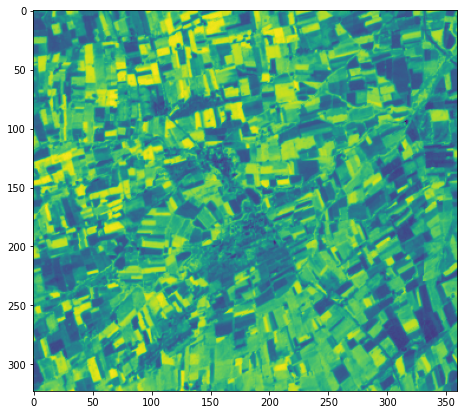

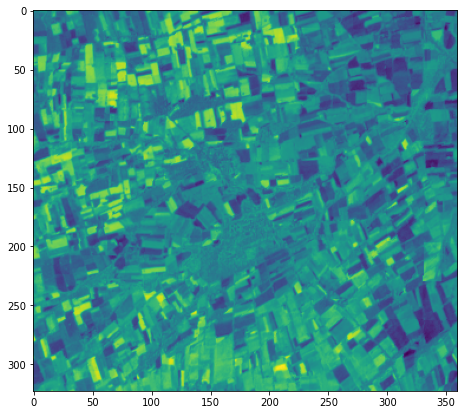

In [12]:
from sklearn import preprocessing
path = "drive/MyDrive/sentinel/navi_chapari/29cca4fc7f475b6e28031e229381f2e2/response.tiff"
src =rasterio.open(path)
ndvi = src.read()
print(ndvi.shape)
plot_image(ndvi[10])
indv_pixel = ndvi.reshape(ndvi.shape[0],ndvi.shape[1]*ndvi.shape[2]).transpose()
indv_pixel = preprocessing.normalize(indv_pixel, norm='l2')
print(indv_pixel.shape)
img_shape = indv_pixel.transpose().reshape(ndvi.shape)
plot_image(img_shape[10])

### **Affinity Propogation**

In [ ]:
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# define dataset
X = indv_pixel
print(type(X))
print(X.shape)
print(X[10])
# define the model
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

<class 'numpy.ndarray'>
(116280, 53)
[0.20230642 0.18697009 0.18857276 0.1876728  0.17286658 0.1887207
 0.18235933 0.1790307  0.17518429 0.17726776 0.17250906 0.17323643
 0.16962426 0.16346014 0.16207937 0.16527239 0.14786491 0.14776629
 0.14483217 0.14489381 0.14065289 0.14340209 0.13996251 0.13835984
 0.13635034 0.13604213 0.13653526 0.13575858 0.13690511 0.13583255
 0.13593118 0.1356353  0.13413125 0.13590652 0.13320663 0.13376141
 0.13252858 0.13330526 0.13236831 0.13369976 0.13085194 0.13648595
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [ ]:
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
# define dataset
X = indv_pixel
print(type(X))
print(X.shape)
print(X[10])
# define the model
model = Birch(threshold=0.01, n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

<class 'numpy.ndarray'>
(116280, 53)
[0.20230642 0.18697009 0.18857276 0.1876728  0.17286658 0.1887207
 0.18235933 0.1790307  0.17518429 0.17726776 0.17250906 0.17323643
 0.16962426 0.16346014 0.16207937 0.16527239 0.14786491 0.14776629
 0.14483217 0.14489381 0.14065289 0.14340209 0.13996251 0.13835984
 0.13635034 0.13604213 0.13653526 0.13575858 0.13690511 0.13583255
 0.13593118 0.1356353  0.13413125 0.13590652 0.13320663 0.13376141
 0.13252858 0.13330526 0.13236831 0.13369976 0.13085194 0.13648595
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [ ]:
from glob import glob
import numpy as np

import rasterio
import json, re, itertools, os

import matplotlib.pyplot as plt

import cv2 as cv
from sklearn import preprocessing
from sklearn.cluster import KMeans

## **Setting up OpenCV**


---



In [ ]:
!pip3 install matplotlib opencv-python 

In [ ]:
import cv2
import matplotlib.pyplot as plt


In [ ]:
# read the image
image = cv2.imread("drive/MyDrive/sentinel/navi_chapari/29cca4fc7f475b6e28031e229381f2e2/build.jpg")

In [ ]:
image = cv2.cvtColor(image, cv2.CV_LOAD_IMAGE_COLOR)
# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

AttributeError: ignored

In [ ]:
_, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)

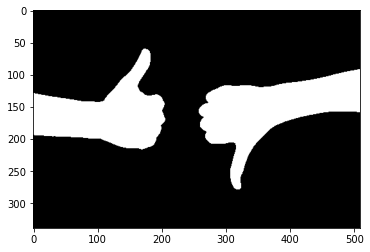

In [ ]:
plt.imshow(binary, cmap="gray")
plt.show()

In [ ]:
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

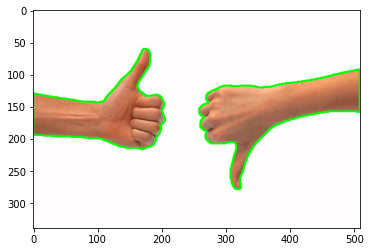

In [ ]:
plt.imshow(image)
plt.show()